# Random Forest Classifier

## Input data (format .x, .graph, and .y)

In [1]:
import sys
from spektral.data import Dataset, Graph
from spektral.transforms import AdjToSpTensor, LayerPreprocess
from sklearn.preprocessing import MinMaxScaler
import pickle as pkl
import networkx as nx
import numpy as np
import scipy.sparse as sp
x_data = []
y_data = []
batch_size = 3  # Batch size
def load_data(circuit_name, path_to_data="data", normalize=False):
    """Load data."""
    names = ["x", "y", "graph"]
    objects = []
    for i in range(len(names)):
        with open(f"{path_to_data}/{circuit_name}.{names[i]}", "rb") as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding="latin1"))
            else:
                objects.append(pkl.load(f))

    x, y, graph = tuple(objects)
    
    x = np.array(x).astype("float32")
    for x_feat in x:
        x_data.append(x_feat)
        
    features = sp.csr_matrix(x).astype('float32')
    # adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph)).astype(int)
    g = nx.DiGraph()
    g.add_nodes_from(graph.keys())
    for k, v in graph.items():
      g.add_edges_from(([(k, t) for t in v]))
      g.add_edges_from([(k, k)])
    adj = nx.adjacency_matrix(g)
    labels = np.array(y).astype('float32').reshape((-1,1))
    for l in y:
        y_data.append(l)
    print(adj.shape)
    print(features.shape)
    return adj, features, labels
  
def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels


def _preprocess_features(features):
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.0
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return features



class CircuitDataset(Dataset):
    def read(self):
        circuits = []
#         circs = ['c6288','c5315','c432', 'c499', 'c17', 'c880', 'c1355', 'c1908', 'c3540', 'adder.bench', 'arbiter.bench', 'cavlc.bench', 'dec.bench', 'voter.bench', "sin.bench","priority.bench", "multiplier.bench", "max.bench"]
        circs = ["adder.bench","arbiter.bench","c1355","c1908","c3540","c432","c499","c5315","c6288","c880","cavlc.bench","dec.bench","int2float.bench","max.bench","multiplier.bench","priority.bench","sin.bench","voter.bench"]
#         circs = ["log2.bench"]
#         circs = ['adder.bench', "arbiter.bench",  "sin.bench", "multiplier.bench", "voter.bench", "priority.bench"]
        for circ in circs:
            A, X, labels = load_data(circ, '../data/output', normalize="")
#             if sum(labels) >= 500:
            print(f"{circ}: {sum(labels)}, {len(labels)}")
            circuits.append(Graph(x=X.toarray(), a=A, y=labels))

        return circuits

def normalize_feature(circ_dataset):
    scaler = MinMaxScaler()
    scaler.fit(x_data)
    for graph in circ_dataset:
        graph.x = scaler.transform(graph.x)
    return circ_dataset

dataset = normalize_feature(CircuitDataset(transforms=[AdjToSpTensor()]))

# Parameters

F = dataset.n_node_features  # Dimension of node features
n_out = dataset.n_labels  # Dimension of the target

# Train/valid/test split
np.random.seed(42)
idxs = np.random.permutation(len(dataset))
split_va, split_te = int(0.8 * len(dataset)), int(0.9 * len(dataset))
idx_tr, idx_va, idx_te = np.split(idxs, [split_va, split_te])
print(idx_tr, idx_va, idx_te)
dataset_tr = dataset[idx_tr]
dataset_va = dataset[idx_va]
dataset_te = dataset[idx_te]
from sklearn.utils.class_weight import compute_class_weight

y_data = []
for data_tr in dataset_tr:
    y_data.append(data_tr.y)
y_data = np.vstack((y_data)).reshape((-1,))


def _compute_class_weight_dictionary(y):
    # helper for returning a dictionary instead of an array
    classes = np.unique(y).astype('float32')
    class_weight = compute_class_weight("balanced", classes, y)
    class_weight_dict = dict(zip(classes, class_weight))
    return class_weight_dict 

weights = _compute_class_weight_dictionary(np.vstack((y_data)).reshape((-1,)))
y_data = []
for data_tr in dataset:
    y_data.append(data_tr.y)
y_data = np.vstack((y_data)).reshape((-1,))

scaler = MinMaxScaler()
scaler.fit(x_data)
x_data = scaler.transform(x_data)

(4209, 4209)
(4209, 4)
adder.bench: [637.], 4209
(36352, 36352)
(36352, 4)
arbiter.bench: [3763.], 36352
(1355, 1355)
(1355, 4)
c1355: [192.], 1355
(1908, 1908)
(1908, 4)
c1908: [257.], 1908
(3540, 3540)
(3540, 4)
c3540: [406.], 3540
(432, 432)
(432, 4)
c432: [60.], 432
(499, 499)
(499, 4)
c499: [50.], 499
(5315, 5315)
(5315, 4)
c5315: [599.], 5315
(6288, 6288)
(6288, 4)
c6288: [846.], 6288
(880, 880)
(880, 4)
c880: [114.], 880
(2164, 2164)
(2164, 4)
cavlc.bench: [318.], 2164
(936, 936)
(936, 4)
dec.bench: [186.], 936
(761, 761)
(761, 4)
int2float.bench: [80.], 761
(9996, 9996)
(9996, 4)
max.bench: [1040.], 9996
(89943, 89943)
(89943, 4)
multiplier.bench: [9294.], 89943
(3495, 3495)
(3495, 4)
priority.bench: [350.], 3495
(16771, 16771)
(16771, 4)
sin.bench: [1723.], 16771
(50122, 50122)
(50122, 4)
voter.bench: [5012.], 50122
[ 0  1  8  5  3 13 16 15 11  2  9 17  4 12] [ 7 10] [14  6]


/Users/vedikasaravanan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0. 1.], y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [2]:
x_data

array([[1.26262626e-03, 0.00000000e+00, 0.00000000e+00, 8.34553994e-27],
       [1.26262626e-03, 0.00000000e+00, 0.00000000e+00, 2.65539907e-26],
       [1.26262626e-03, 0.00000000e+00, 0.00000000e+00, 4.55211270e-26],
       ...,
       [2.20959596e-01, 3.52941176e-02, 4.98642947e-13, 3.23776014e-12],
       [2.22222222e-01, 3.72549020e-02, 4.99319855e-13, 3.23708318e-12],
       [2.37373737e-01, 4.31372549e-02, 3.73640309e-12, 0.00000000e+00]])

In [3]:
y_data

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import linear_model, tree, ensemble
X_train, X_test, y_train, y_test = train_test_split(x_data,y_data,test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(187972, 4) (187972,)
(46994, 4) (46994,)


In [5]:
kf =KFold(n_splits=5, shuffle=True, random_state=42)

cnt = 1
# split()  method generate indices to split data into training and test set.
for train_index, test_index in kf.split(x_data, y_data):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt += 1

Fold:1, Train set: 187972, Test set:46994
Fold:2, Train set: 187973, Test set:46993
Fold:3, Train set: 187973, Test set:46993
Fold:4, Train set: 187973, Test set:46993
Fold:5, Train set: 187973, Test set:46993


In [6]:
def rmse(score):
    rmse = np.sqrt(-score)
    print(f'rmse= {"{:.2f}".format(rmse)}')

In [7]:
score = cross_val_score(ensemble.RandomForestClassifier(random_state= 42), x_data, y_data, cv=kf)
print(f'Scores for each fold: {score}')

Scores for each fold: [0.91173341 0.9110293  0.90983764 0.90907156 0.91056115]


In [8]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cnt = 1
# split()  method generate indices to split data into training and test set.
for train_index, test_index in kf.split(x_data, y_data):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt+=1
    

Fold:1, Train set: 187972, Test set:46994
Fold:2, Train set: 187973, Test set:46993
Fold:3, Train set: 187973, Test set:46993
Fold:4, Train set: 187973, Test set:46993
Fold:5, Train set: 187973, Test set:46993


In [9]:
score = cross_val_score(ensemble.RandomForestClassifier(random_state= 42,class_weight = weights), x_data, y_data, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')

Scores for each fold are: [0.84604418 0.84650905 0.84642394 0.8464665  0.84504075]
Average score: 0.85


In [10]:
max_depth = [1,2,3,4,5,6,7,8,9,10]
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
for val in max_depth:
    score = cross_val_score(ensemble.RandomForestClassifier(max_depth= val, random_state= 42), x_data, y_data, cv= kf, scoring="accuracy")
    print(f'Average score({val}): {"{:.3f}".format(score.mean())}')

Average score(1): 0.894
Average score(2): 0.894
Average score(3): 0.895
Average score(4): 0.900
Average score(5): 0.901
Average score(6): 0.903
Average score(7): 0.904
Average score(8): 0.906
Average score(9): 0.907
Average score(10): 0.908


In [11]:
def evaluate_model(data_x, data_y):
    k_fold = KFold(10, shuffle=True, random_state=1)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x):
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]

        # Fit the classifier
        classifier = ensemble.RandomForestClassifier().fit(train_x, train_y)

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets

In [12]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

In [13]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

Confusion matrix, without normalization


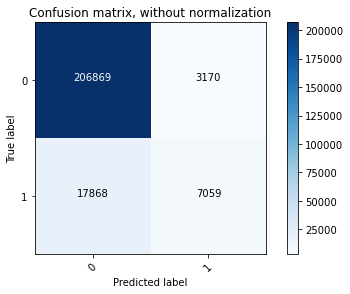

Normalized confusion matrix


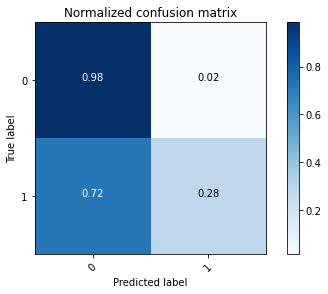

In [14]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
class_names = ['0','1']
predicted_target, actual_target = evaluate_model(x_data, y_data)
plot_confusion_matrix(predicted_target, actual_target)